In [ ]:
import torch
import random
import numpy as np
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
import torchvision.datasets
# Загружаем датасет USPS
USPS_train = torchvision.datasets.USPS(root='./', download=True, train=True)
USPS_test = torchvision.datasets.USPS(root='./', download=True, train=False)

100%|██████████| 6.58M/6.58M [00:01<00:00, 4.69MB/s]


100%|██████████| 1.83M/1.83M [00:01<00:00, 1.68MB/s]


In [ ]:
# Формируем датасеты для обучения и тестирования
X_train = USPS_train.data
y_train = USPS_train.targets
X_test = USPS_test.data
y_test = USPS_test.targets

In [ ]:
# Названия классов (цифры от 0 до 9)
classes = list(range(10))
classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
# Проверяем размерность данных
X_train.shape # 7291 изображение размером 16x16 пикселей

(7291, 16, 16)

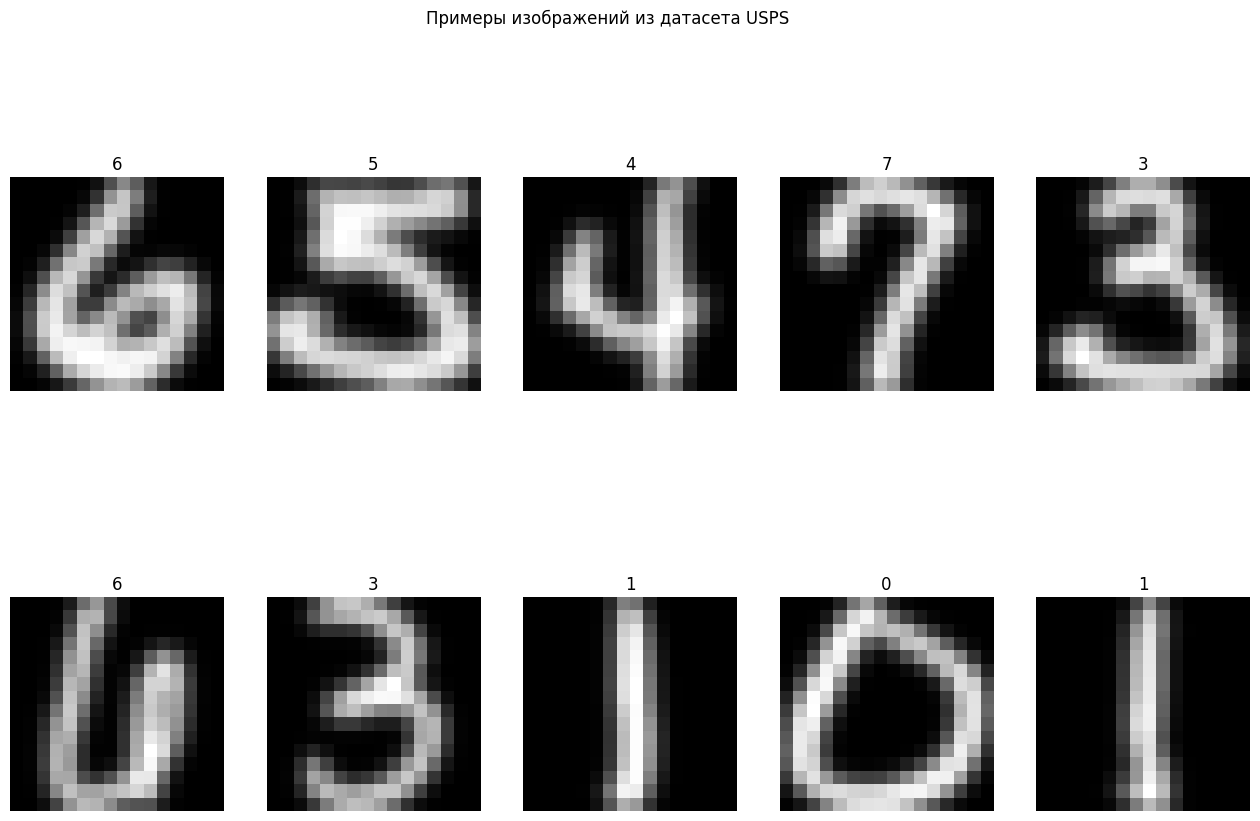

In [ ]:
# Посмотрим на то, как выглядят картинки из датасета.
import matplotlib.pyplot as plt
%matplotlib inline

hh = 2
ww = 5

fig, ax = plt.subplots(hh, ww, figsize=(16, 5 * hh))
fig.suptitle("Примеры изображений из датасета USPS ")

for i, (x, y) in enumerate(zip(X_train, y_train)):
    if i >= hh * ww: # # Останавливаемся, если вывели 10 изображений
        break
    plt.subplot(hh, ww, i + 1)
    plt.imshow(x.reshape(16, 16), cmap="gray")
    plt.axis('off')
    plt.title(classes[y])
plt.show()

In [ ]:
# Преобразование массива NumPy в тензор
# unsqueeze - Возвращает новый тензор с увеличенной на 1 размерностью, которая вставляется в указанную позицию.
# и все значения - во float
X_train = torch.tensor(X_train).unsqueeze(1).float()  # Добавляем размерность и приводим к float
X_test = torch.tensor(X_test).unsqueeze(1).float()    # Аналогично для тестовой выборки
y_train = torch.tensor(USPS_train.targets, dtype=torch.long)
y_test = torch.tensor(USPS_test.targets, dtype=torch.long)

In [ ]:
# Нормализуем зжначения пикселей (к диап. [0;1])
X_train = torch.tensor(X_train.data) / 255.
X_test = torch.tensor(X_test.data) / 255.

<ipython-input-8-f12873268e41>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train.data) / 255.
<ipython-input-8-f12873268e41>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test.data) / 255.


In [ ]:
X_train.shape

torch.Size([7291, 1, 16, 16])

In [ ]:
print(X_train.min(), X_train.max(), X_train.dtype, sep="\n")

tensor(0.)
tensor(0.9961)
torch.float32


In [ ]:
# Напишем свой блок свёртки с residual connection.
class ResidualBlock(torch.nn.Module):
    # Инициализация блока.
    def __init__(
        self,
        input_c,                   # Число каналов на входе.
        output_c,                  # Число каналов на выходе.
        kernel_size,               # Размер ядра.
        activation=torch.nn.ReLU,  # Класс функции активации.
    ):
        super().__init__()

        # Функция активации для нелинейности.
        self.activation = activation()

        # TODO:
        # Паддинг подбираем такой, чтобы размеры h и w не менялись
        #  (считаем, что размер ядра всегда нечётный).
        padding_size = kernel_size // 2

        # TODO:
        # Операция свёртки.
        # Создайте сверточный слой с помощью класса torch.nn.Conv2d
        # укажите количество каналов на входе и выходе, размер ядра,
        # размер паддинга и режим его выполнения (заполнение нулями)
        self.conv = torch.nn.Conv2d(
            in_channels=input_c,         # Число каналов на входе.
            out_channels=output_c,       # Число каналов на выходе.
            kernel_size=kernel_size,         # Размер ядра.
            padding=padding_size,             # Размер паддинга (1 элемент добавляется с каждой стороны).
            padding_mode="zeros",  # Указываем, что в паддинге проставляем нули вдоль границ входного тензора.
            stride=1,              # Stride - 1 (смотрим на каждую позицию).
            dilation=1,            # Dilation - 1 (ядро прикладывается к фрагменту изображения без пропусков).
        )

        # Если числа каналов у входа и выхода различаются,
        if input_c != output_c:
            # ТОDO:
            # то будем делать свёртку с ядром размера 1.
            self.correct_channels = torch.nn.Conv2d(
                in_channels=input_c,         # Число каналов на входе.
                out_channels=output_c,       # Число каналов на выходе.
                kernel_size=1,         # Размер ядра.
                padding=0,             # Размер паддинга (1 элемент добавляется с каждой стороны).
                padding_mode="zeros",  # Указываем, что в паддинге проставляем нули вдоль границ входного тензора.
                stride=1,              # Stride - 1 (смотрим на каждую позицию).
                dilation=1,
        )
        else:
            self.correct_channels = torch.nn.Identity()  # Слой, никак не меняющий вход.

    # Прямой проход.
    def forward(self, x):
        # ТОDO:
        # реализуйте прямой проход
        return self.activation(self.conv(x)) + self.correct_channels(x)

In [ ]:
# Определяем класс, который будет представлять нашу нейронку
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2) # 16x16 -> 16x16
        self.act1  = torch.nn.ReLU() # ReLU заменяет отрицательные значения на ноль, а положительные оставляет без изменений.
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2) # 16x16 -> 8x8

        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0) # 8x8 -> 4x4
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2) # 4x4 -> 2x2

        self.fc1   = torch.nn.Linear(16 * 2 * 2, 120) # 16 * 2 * 2 = 64
        self.act3  = torch.nn.ReLU()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.ReLU()

        self.fc3   = torch.nn.Linear(84, 10)

    def forward(self, x):
      x = self.conv1(x)  #  Свёртка 5×5, выход (6, 16, 16)
      x = self.act1(x)
      x = self.pool1(x)  #  Пулинг 2×2 → (6, 8, 8)

      x = self.conv2(x)  #  Свёртка 5×5, выход (16, 4, 4)
      x = self.act2(x)
      x = self.pool2(x)  #  Пулинг 2×2 → (16, 2, 2)

      x = x.view(x.size(0), -1)  #  Разворачиваем тензор (batch, 16*2*2 = 64)
      x = self.fc1(x)            #  Полносвязный слой → 120
      x = self.act3(x)

      x = self.fc2(x)  # Полносвязный слой → 84
      x = self.act4(x)

      x = self.fc3(x)  # Финальный слой → 10 (число классов)

      return x

# Переменная - наша нейронка
lenet5 = LeNet5()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [ ]:
# в качестве функции потерь будем использовать CrossEntropyLoss()
loss_fn = torch.nn.CrossEntropyLoss()
# в качестве оптимайзера, который будет вычислять градиенты и минимизировать функцию потерь, будем использовать Adam (Адаптивная оценка момента)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

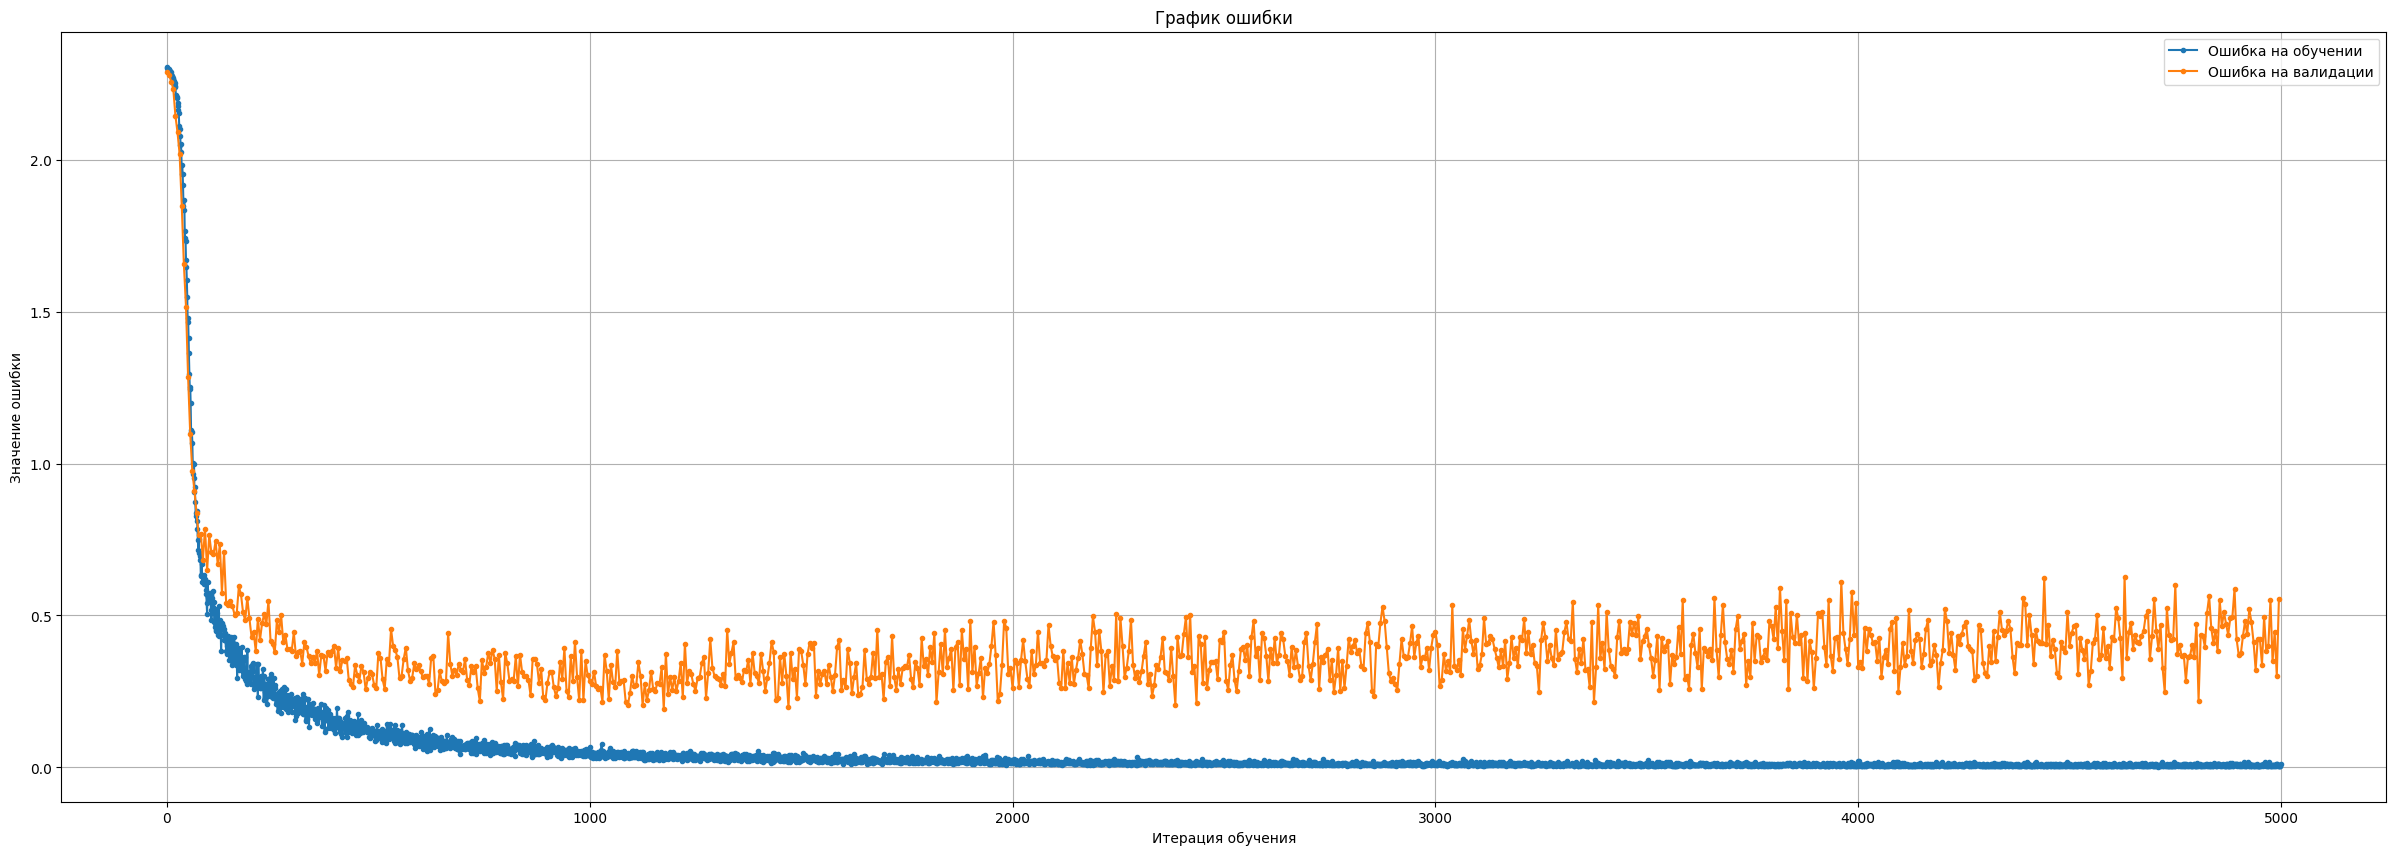

In [ ]:
from IPython.display import clear_output

losses = {"train": [], "val": []}

# Шедулер (scheduler) отвечает за изменение величины шага градиентного спуска, который
#  в данном случае мы будем постепенно уменьшать с течением времени.
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

num_epochs = 5000
batch_size = 1000
val_every = 5

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()

    batch_pos = torch.randint(high=X_train.shape[0], size=[batch_size])

    pred = lenet5.forward(X_train[batch_pos].to(device))  # Также переносим тензоры на устойство.
    loss = loss_fn(pred, y_train[batch_pos].to(device))

    loss.backward()
    optimizer.step()

    losses["train"].append(loss.item())

    # Каждые val_every итераций считаем значение loss на валидационной выборке.
    if epoch % val_every == 0:
        with torch.no_grad ():
            val_batch_pos = torch.randint(high=X_test.shape[0], size=[batch_size])
            val_pred = lenet5(X_test[val_batch_pos].to(device))
            val_loss = loss_fn(val_pred, y_test[val_batch_pos].to(device))
            losses["val"].append(val_loss.item())

    # Каждые 1000 итераций уменьшаем шаг градиентного спуска.
    if epoch % 1000 == 0:
        scheduler.step()

    # Каждые 100 итераций рисуем графики loss.
    if epoch % 100 == 0:
        print('epoch', epoch)
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("График ошибки")
        plt.plot(losses["train"], ".-", label="Ошибка на обучении")
        plt.plot(torch.arange(0, epoch, val_every), losses["val"], ".-", label="Ошибка на валидации")
        plt.xlabel("Итерация обучения")
        plt.ylabel("Значение ошибки")
        plt.legend()
        plt.grid()
        plt.show()

In [ ]:
classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
def show_results(model, h=2, w=5):
    with torch.no_grad():
        batch_indices = torch.randint(0, X_test.shape[0], (h * w,))
        batch_images = X_test[batch_indices].to(device)
        batch_labels = y_test[batch_indices].cpu().numpy()
        batch_probs = torch.nn.functional.softmax(model(batch_images), dim=1)

        fig, axes = plt.subplots(h, w, figsize=(20, 8 * h))
        axes = axes.flatten() if h * w > 1 else [axes]

        for i, ax in enumerate(axes):
            img = batch_images[i].cpu().numpy().reshape(16, 16)
            real_class = int(batch_labels[i])  # Приводим y_test к int
            y_pred = torch.argmax(batch_probs[i]).item()

            # Заголовок
            title = f'Реальный класс: {classes[real_class]}\n\nПредсказания:'
            for j in range(len(classes)):
                prob = round(batch_probs[i][j].item(), 4)
                title += f'\n{" >" if j == y_pred else "  "}'
                title += f'{" +" if j == real_class else "  "} {classes[j]} : {prob}'

            ax.imshow(img, cmap="gray")
            ax.set_title(title)
            ax.axis('off')

        plt.show()

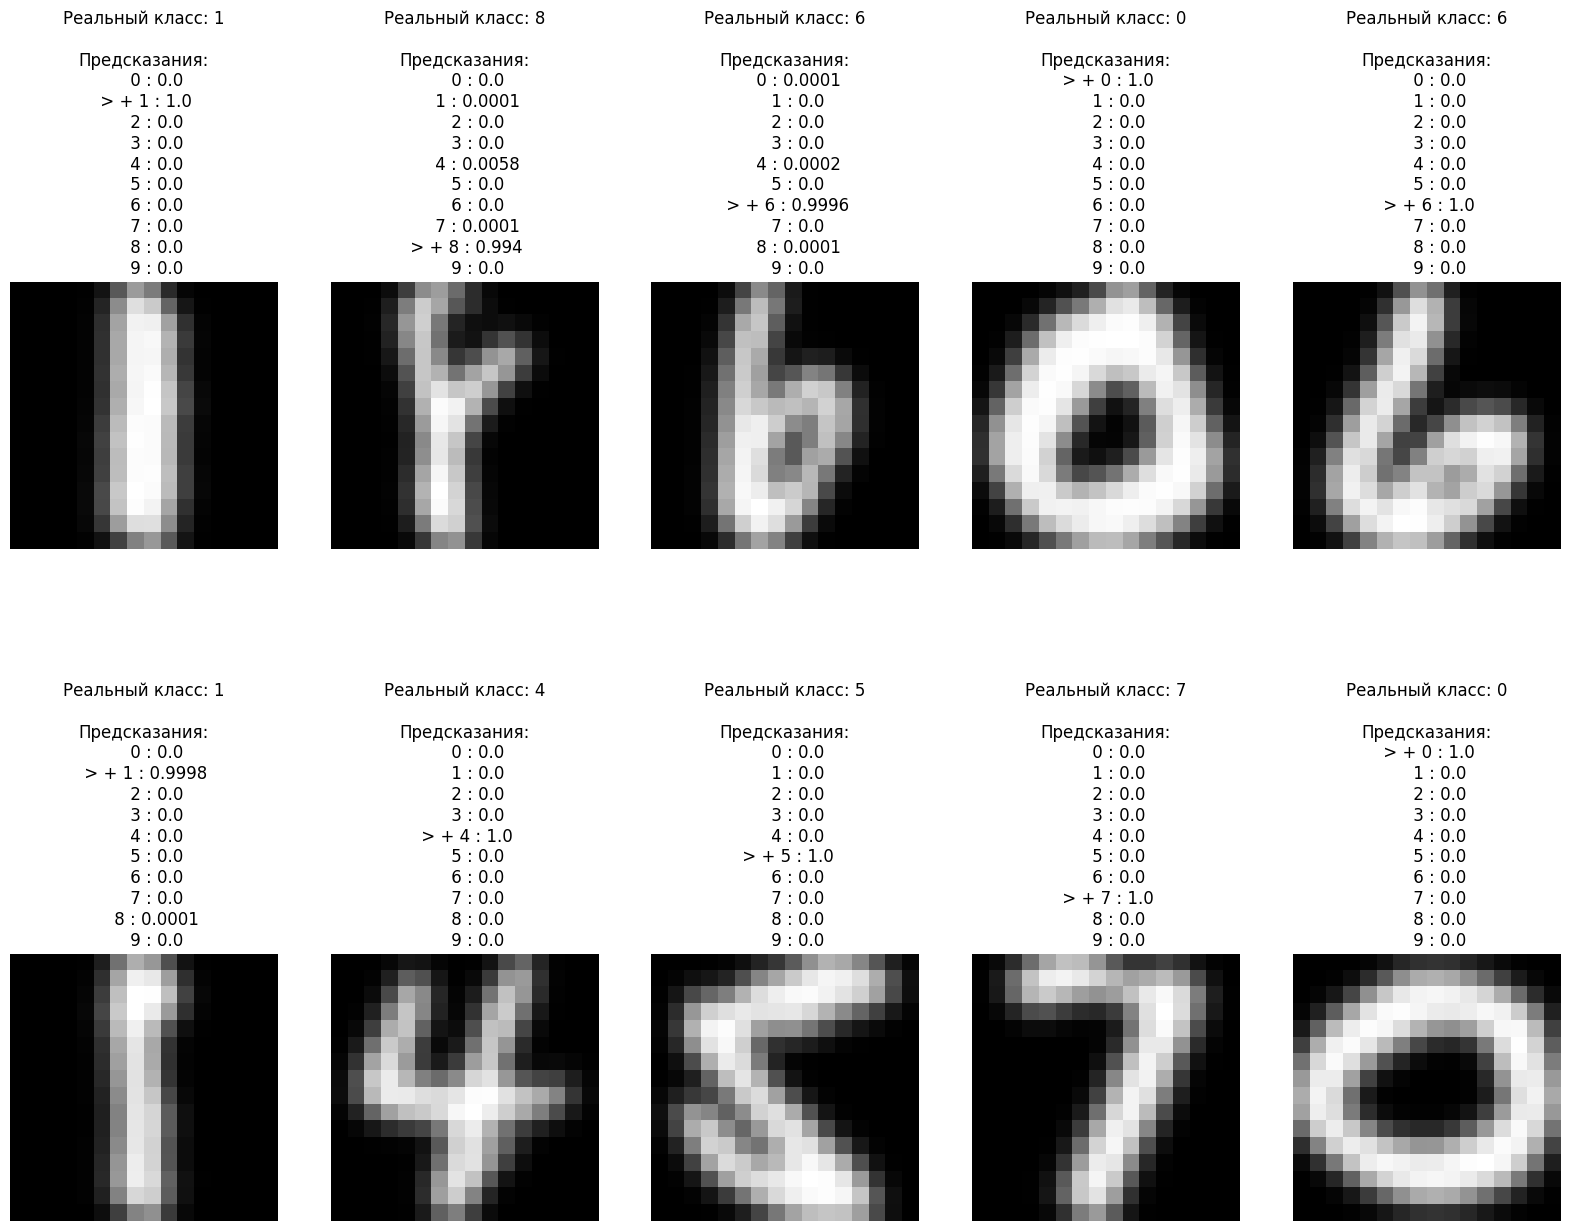

In [ ]:
show_results(lenet5)